# MONTE CARLO DROPOUT
Incerteza Epistêmica em Redes Neurais - Gerson Eduardo de Mello 

Esta é uma aplicação do método de incerteza em redes neurais proposto por Yarin Gal. O Dataset escolhido simulado aleatoriamente de um ensai ode tração onde a função é perfeitamente conhecida, ou seja  T=4*F/(D².pi). Assim espera-se um resultado muito satisfatório uma vez que foram criados 1000 resultados deste ensaio vaiando F de 100 a 400 N e vartiando D de 50 a 150 mm. Foram usados 70% no treino e 30% no teste.

#Descrição do método proposto por Yarin Gal: 

Em 2015, Yarin Gal mostrou que é possível obter incerteza a partir de redes neurais quase que gratuitamente, se olhássemos técnicas de regularização estocásticas, como Dropout, sob uma perspectiva Bayesiana. Dropout (Srivastava et al, ‎2014) é uma técnica utilizada na maioria das redes neurais modernas para prevenir sobre-ajustamento. Durante o treinamento, Dropout funciona zerando aleatoriamente uma percentagens de neurônios nas camadas da rede neural. No momento de fazer previsões, todos os neurônios são mantidos e a rede neural atua como uma grande mistura de sub-redes menores.
Durante o treinamento do modelo, nada muda; mas, durante o teste mantemos a probabilidade de Dropout fixada durante o treino e realizamos T  forward-pass pela rede, coletando assim T  previsões y para cada amostra. Assim para cada ponto teremos uma previsão para a média e uma previsão para a variância, que será nossa medida de incerteza.
 

In [57]:
# Importando as bibliotecas necessárias para importação dos datasets

In [43]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use("ggplot")

In [44]:
# importando os dados  de reflectância em % obtidos pela  espectroscopia de reflectância infravermelha (vis-NIR)

In [45]:
X_train=pd.read_csv('x_treino.csv')

In [46]:
X_train 

,F,D
0,295,82
1,113,83
2,236,122
3,250,126
4,136,134
...,...,...
695,226,120
696,297,59
697,201,106
698,255,84


In [47]:
X_test=pd.read_csv('x_teste.csv')

In [48]:
X_test

,F,D
0,274,96
1,127,61
2,119,61
3,354,124
4,334,87
...,...,...
295,293,134
296,203,84
297,105,70
298,350,106


In [49]:
y_train=pd.read_csv('y_treino.csv')

In [50]:
y_train

,T
0,0.055889
1,0.020895
2,0.020199
3,0.020060
4,0.009648
...,...
695,0.019993
696,0.108688
697,0.022788
698,0.046038


In [51]:
y_test=pd.read_csv('y_teste.csv')

In [52]:
y_test

,T
0,0.037874
1,0.043478
2,0.040740
3,0.029329
4,0.056213
...,...
295,0.020787
296,0.036649
297,0.027298
298,0.039681


In [68]:
#importando bibliotecas para construção da rede neural 

In [53]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2

In [70]:
#construimos a rede neural

In [198]:
n_input = 2 # numero de entradas das rede neural ( força e diâmetro)
num_out = 1  # numero de saídas da rede neural (tração)

p_dropout = 0.01 # probabilidade dropout 
lbd = 1e-4  # L2- força de regularização 

model = Sequential()
model.add(Dropout(.05, input_shape=(n_input,)))
model.add(Dense(100, activation='relu', input_shape=(n_input,), kernel_regularizer=l2(lbd)))
model.add(Dropout(p_dropout))
model.add(Dense(100, activation='relu', kernel_regularizer=l2(lbd)))
model.add(Dropout(p_dropout))
model.add(Dense(num_out, activation=None))
model.summary()

opt = Adam(lr=1e-3)

model.compile(loss='mean_squared_error',
              optimizer=opt,
              metrics=['mean_absolute_error'])

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_78 (Dropout)        (None, 2)                 0         
                                                                 
 dense_78 (Dense)            (None, 100)               300       
                                                                 
 dropout_79 (Dropout)        (None, 100)               0         
                                                                 
 dense_79 (Dense)            (None, 100)               10100     
                                                                 
 dropout_80 (Dropout)        (None, 100)               0         
                                                                 
 dense_80 (Dense)            (None, 1)                 101       
                                                                 
Total params: 10,501
Trainable params: 10,501
Non-tra

/home/gerson/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [199]:
#treinamos nossa rede por 15000 interações . Cada mini-lote terá 1/5das amostras e assim treinaremos por
# 3000 épocas ou 15000 iterações.

In [200]:
epochs = 3000
model.fit(X_train, y_train,
            batch_size=X_train.shape[0] // 5,
            epochs=epochs,
            verbose=0)

In [182]:
#Avaliamos a performance do modelo usaremos o MAE ( mean absolute error)

In [183]:
#Avaliando o MAE no treino

In [201]:
from sklearn import metrics

y_hat_train = model.predict(X_train)
metrics.mean_absolute_error(y_train, y_hat_train)


22/22 [==============================] - 0s 645us/step


0.0071516042287782765

In [177]:
#Avaliando o ajuste no treino

In [212]:
MAE_T=metrics.mean_absolute_error(y_train, y_hat_train)
R2_T=metrics.r2_score(y_train, y_hat_train);
RMSE_T=metrics.mean_squared_error(y_train, y_hat_train)

In [213]:
MAE_T,R2_T,RMSE_T

(0.0071516042287782765, 0.9099318253945455, 9.807020447620989e-05)

In [203]:
y_hat_test = model.predict(X_test)
metrics.mean_absolute_error(y_test, y_hat_test)

10/10 [==============================] - 0s 892us/step


0.006565094141173927

In [215]:
MAE_t=metrics.mean_absolute_error(y_test, y_hat_test)
R2_t=metrics.r2_score(y_test, y_hat_test);
RMSE_t=metrics.mean_squared_error(y_test, y_hat_test)

In [216]:
MAE_t,R2_t,RMSE_t

(0.006565094141173927, 0.9093122208243861, 8.345621435428666e-05)

In [196]:
# elaboração do gráfico ordenando os dados em ordem e plotando os valores da tração real e predita no conjunto de teste 

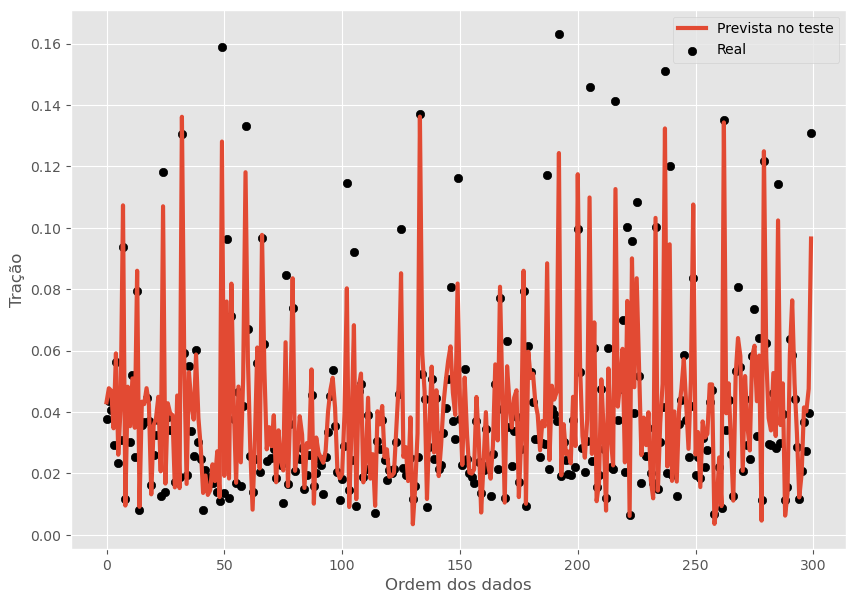

In [217]:
# avaliação conjunto de teste
n = 300
plt.style.use("ggplot")
f = plt.figure(figsize=(10,7))
plt.plot(range(n), y_hat_test, label="Prevista no teste", lw=3)
plt.scatter(range(n), y_test, color="black", label="Real")
plt.ylabel("Tração")
plt.xlabel("Ordem dos dados")
plt.legend(loc="best")
f.savefig("rnn_demanda1.png")
plt.show()

Acima, a previsão é feita da forma tradicional, isto é, colocando a probabilidade de Dropout em 0%, usando assim toda a capacidade da rede. Esse é o padrão do Keras e precisaremos rescrevê-lo para implementar Monte-Carlo Dropout, no qual mantemos as probabilidades de Dropout de treino também durante as previsões. Abaixo, vamos definir uma função que retornará a última camada da rede, (as previsões) dada a camada de entrada (as variáveis). Além disso, vamos definir que está função será usada tal como durante o treinamento, passando K.learning_phase().
Abaixo realizamos 1000 forwad-passes pela rede neural e obtemos 1000 previsões para cada ponto.

In [218]:
import tensorflow as tf
import numpy as np
from keras import backend as K

T = 1000

tf.keras.backend.set_learning_phase(1)

predict_stochastic = K.function([model.layers[0].input], [model.layers[-1].output])

y_hat_mc = np.array([predict_stochastic([X_test]) for _ in range(T)])

y_hat_mc = y_hat_mc.reshape(-1, y_test.shape[0]).T

/home/gerson/anaconda3/lib/python3.9/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


ValueError: Exception encountered when calling layer 'dropout_78' (type Dropout).

`x.dtype` must be a floating point tensor as `x` will be scaled. Received: x_dtype=<dtype: 'int64'>

Call arguments received by layer 'dropout_78' (type Dropout):
  • inputs=       F    D
0    274   96
1    127   61
2    119   61
3    354  124
4    334   87
..   ...  ...
295  293  134
296  203   84
297  105   70
298  350  106
299  257   50

[300 rows x 2 columns]
  • training=True

In [128]:
y_hat_mc.shape

NameError: name 'y_hat_mc' is not defined

In [81]:
#Computamos média e variância para cada ponto no set de teste.

In [219]:
l = 10
y_hat_test_mean = np.mean(y_hat_mc, axis=1) # média das 1000 previsões para cada ponto 
y_hat_test_variance = np.var(y_hat_mc, axis=1) 
tau = l**2 * (1 - p_dropout) / (2 * X_train.shape[0] * lbd)
y_hat_test_variance += tau**-1  # variância das 1000 previsões para cada ponto 

NameError: name 'y_hat_mc' is not defined

In [83]:
metrics.mean_absolute_error(y_test, y_hat_test_mean)

4.256481344049627

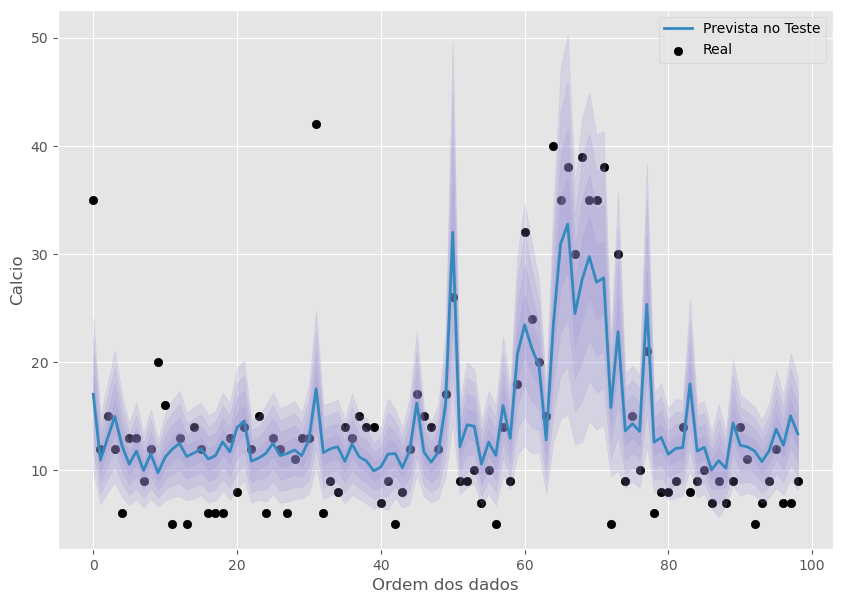

In [84]:
n = 99
t = range(n) 
mu = y_hat_test_mean
sigma = np.sqrt(y_hat_test_variance)

plt.style.use("ggplot")
f = plt.figure(figsize=(10,7))
plt.plot(t, mu, label="Prevista no Teste", color="C1", lw=2)
plt.scatter(t, y_test, color="black", label="Real")

for shade in range(1, 5):
    plt.fill_between(t, mu+sigma* (.5*shade), mu-sigma * (.5*shade), alpha=0.2, color="C2")

plt.ylabel("Calcio")
plt.xlabel("Ordem dos dados")
plt.legend(loc="best")
f.savefig("rnn_demanda_test.png")
plt.show()

In [42]:
T = 1000

tf.keras.backend.set_learning_phase(1)

predict_stochastic = K.function([model.layers[0].input], [model.layers[-1].output])

y_hat_mc = np.array([predict_stochastic([X_train]) for _ in range(T)])

y_hat_mc = y_hat_mc.reshape(-1, y_train.shape[0]).T

/home/gerson/anaconda3/lib/python3.9/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


ValueError: Exception encountered when calling layer 'dropout_9' (type Dropout).

`x.dtype` must be a floating point tensor as `x` will be scaled. Received: x_dtype=<dtype: 'int64'>

Call arguments received by layer 'dropout_9' (type Dropout):
  • inputs=       F    D
0    399  149
1    289   56
2    103   42
3    282  162
4    327   25
..   ...  ...
990  323  125
991  318   31
992  254   62
993  193  128
994  270   81

[995 rows x 2 columns]
  • training=True

In [86]:
l = 10
y_hat_train_mean = np.mean(y_hat_mc, axis=1)
y_hat_train_variance = np.var(y_hat_mc, axis=1)
tau = l**2 * (1 - p_dropout) / (2 * X_train.shape[0] * lbd)
y_hat_train_variance += tau**-1

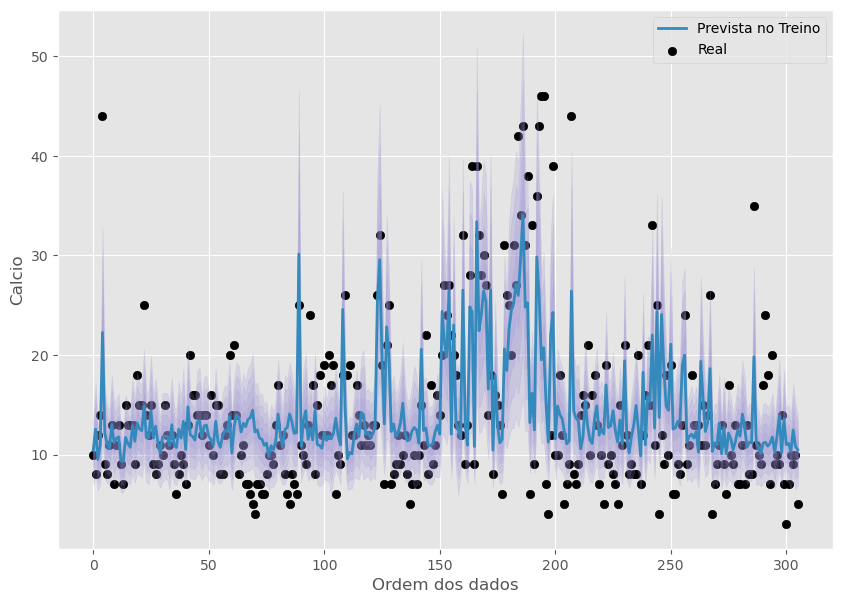

In [87]:
n = 306
t = range(n) 
mu = y_hat_train_mean
sigma = np.sqrt(y_hat_train_variance)

plt.style.use("ggplot")
f = plt.figure(figsize=(10,7))
plt.plot(t, mu, label="Prevista no Treino", color="C1", lw=2)
plt.scatter(t, y_train, color="black", label="Real")

for shade in range(1, 5):
    plt.fill_between(t, mu+sigma* (.5*shade), mu-sigma * (.5*shade), alpha=0.2, color="C2") # 90% IC

plt.ylabel("Calcio")
plt.xlabel("Ordem dos dados")
plt.legend(loc="best")
f.savefig("rnn_demanda_train.png")
plt.show()